# 프로젝트: 폐렴 진단기 성능 개선
- 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들었음
- 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 개선해서 성능 향상

<center> <span style="color:blue; font-weight:bold; font-size:20px">Step별 성능개선 관련 항목</span> </center>

| # | Step | 성능개선 관련 항목 |
|:---:|:---|:---|
| Step 1 | 실험환경 Set-up | - batch size, epoch |
| Step 2 | 데이터 준비하기 | augmentation 기법 고려 가능 <br> - 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 <br> augmentation들이 항상 도움이 된다고 말할 수 없음 <br> - 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 <br> 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 <br> 부수효과가 오히려 방해를 줄 수도 있음 <br> - **좌우 반전 정도의 augmentation만 도입** |
| Step 3 | 데이터 시각화 | - 실제로 좌우 반전 등이 제대로 처리되었는지 확인 |
| Step 4 | CNN 모델링 | - convolution filter, 채널 개수, activation, 모델 구조 등 <br> - **batch normalization, dropout 각각 사용** <br> - dropout 비율 변경 |
| Step 5 | 데이터 imbalance 처리 | - class_weight 처리를 생략하는 경우 <br> - recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 <br> 더 강화하는 효과를 만들어내는 방법 |
| Step 6 | 모델 훈련 | - optimizer, learning rate |
| Step 7 | 결과 확인과 시각화 | - accuracy, recall <br> - 훈련과정의 history 그래프를 시각화해 보고, <br> 학습 진행 양상을 면밀히 분석 |


## Step 1. 실험환경 Setup
- Batch size, Epoch 등을 변경해볼 수 있음

- 패키지(라이브러리) import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
# 추가
from tensorflow import keras
import tensorflow_datasets as tfds
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

- 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
#IMAGE_SIZE = [180, 180]
IMAGE_SIZE = [224, 224] # 확정
#IMAGE_SIZE = [500, 500]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 50

- <span style="color:blue; font-weight:bold; font-size:15px">BATCH_SIZE = 4, 8, 16, 32, 64를 사용하여 실행한 결과, 16에서 제일 좋은 성능(accuracy 기준)을 보임 </span>
- EarlyStopping 콜백 적용하므로 지정한 EPOCHS(=50)에 관계없이 최고 성능을 보이는 에포크에서 스톱
  - 대개의 경우, 에포크 10 이내에서 종료되었음. 넉넉하게 50으로 지정

## Step 2. 데이터 준비하기
- 원본 데이터를 가져와서 전처리 및 배치 구성 진행
- 의료 영상 이미지의 특성상 데이터는 언제나 불충분

### 2-1. 각 데이터 개수 확인 후 훈련(train), 검증(validation) 데이터셋 재구성

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train : test : val = 89.1% : 10.7% : 0.3% (5856=5216+624+16)
- 검증용 데이터(val) 개수가 너무 적으므로 train과 val에 있는 데이터를 모은 후 train:val를 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 4185개, test 624개, val은 1047개

### 2-2. train 데이터셋의 정상 이미지 및 폐렴 이미지 개수 확인

  - 정상 이미지와 폐렴 이미지 파일 경로 확인

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


- 파일 경로에 NORMAL, PNEUMONIA 확인하여 이미지 개수 파악

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 정상(1,072개)보다 폐렴(3,113개) 이미지 수가 3배 더 많음
  - CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘함
  - **데이터의 클래스 불균형(imbalance) 문제는 Step 5에서 처리** 
- test와 val 데이터셋은 학습과 관련 없으므로 imbalance한 데이터 셋이어도 문제없음

### 2-3. tf.data 인스턴스 만들기 
  - tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

i = 0
for elem in val_list_ds:
    print(elem.numpy())
    i += 1
    if i > 5:
        break

b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0596-0001.jpeg'
b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1519_bacteria_3970.jpeg'
b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person20_bacteria_64.jpeg'
b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person437_bacteria_1885.jpeg'
b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1929_bacteria_4839.jpeg'
b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person592_bacteria_2431.jpeg'


- Train 데이터셋, validation 데이터셋 개수 확인

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 2-4. 라벨 데이터 (함수) 만들기: get_label()
- 파일이름에 들어있는 경로명을 보고 구별
  - NORMAL = 음성 = False = Class 0
  - PNEUMONIA = 양성 = True = Class 1

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2-5. 이미지 크기 통일 및 줄이기 (함수): decode_img(), process_path()
- 현실 이미지 크기는 각각, 통일 필요
- GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 크기 축소
  - decode_img 함수: 이미지를 숫자(정수)로 변환 후 이미지 크기를 축소
  - process_path 함수: 
    - file_path를 입력으로 받아서
    - 라벨 검출: get_label 함수 사용
    - 이미지 읽고
    - decode_img 함수 실행: 이미지를 숫자로 바꾸고 사이즈 변경

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    
    #추가 시작
    #img = (img/127.5) - 1 # 픽셀값의 scale 수정
    #추가 끝
    
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### 2-6. 훈련(train) 데이터셋, 검증(validation) 데이터셋 만들기
- num_parallel_calls 파라미터에 AUTOTUNE 변수를 지정: 더욱 빠르게 데이터 처리 가능

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 2-7. 훈련, 검증 데이터셋 전처리 결과 확인
- 이미지가 잘 리사이즈 되었는지
- 라벨이 잘 들어가 있는지

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


- 사이즈 변환 OK, 라벨 OK
- train_ds.take(1)은 하나의 데이터만 가져온다는 의미

### 2-8. 테스트(test) 데이터셋 전처리 및 결과 확인
- 위(2-3 ~ 2-7)와 같은 방법 사용

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2-9. 효율적 훈련(학습)을 위한 훈련데이터 구성 (함수 정의 포함)
- tf.data API 사용 prepare_for_training() 함수 정의: 데이터 변환
  - shuffle(): 고정 크기 버퍼(1000) 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
  - repeat(): 데이터셋을 무한 반복 사용. 4185개 데이터를 계속 이어서 무한 사용
  - batch(): BATCH_SIZE에서 정한 만큼을 뽑음. 1000개 중에서 16개씩 뽑음.
  - prefetch(): 다음 데이터 1000개를 미리 준비. 리소스(CPU)의 유휴 상태를 줄일 수 있음

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
#train_ds = prepare_for_training(train_ds)
#val_ds = prepare_for_training(val_ds)

### 2-10. 좌우 반전 augmentation 기법 고려
- 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없음
- 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있음
- augmentation 도입은 신중해야
<br> <br>
- 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행:

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training_aug(train_ds)
val_ds = prepare_for_training_aug(val_ds)

#### 데이터 전처리 결과 확인
- train_ds.take(1)으로 하나의 데이터만 가져와서
- 이미지가 잘 리사이즈 되었는지
- 라벨이 잘 들어가 있는지

In [18]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

train_ds

Image shape:  (16, 224, 224, 3)
Label:  [ True  True False  True  True  True  True  True  True False  True False
  True  True  True  True]


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.bool)>

## Step 3. 데이터 시각화
- train에 있는 batch 중 첫 번째 배치를 추출
- 추출된 배치를 image와 label 데이터셋으로 나눔
- show_batch() 함수를 이용해서 결과 사진 확인
<br> <br>
- augmentation 시도시 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인 필요

Image shape:  (16, 224, 224, 3)
Label:  [ True False  True False  True  True  True  True  True  True  True  True
 False  True  True  True]


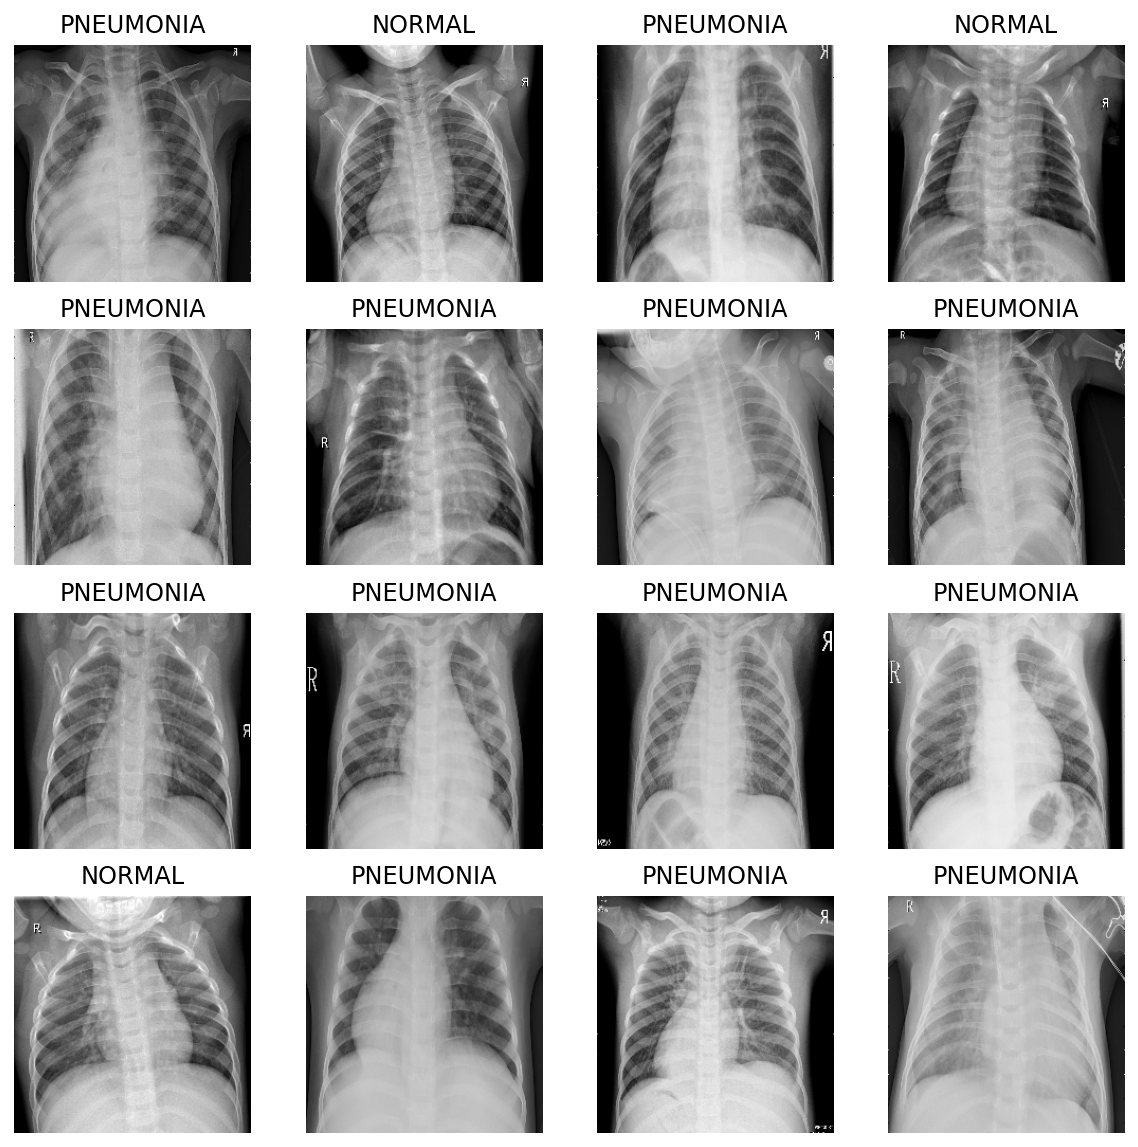

In [19]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        # 추가 시작
        #image_batch[n] = (image_batch[n] + 1) * 127.5
        #추가 끝
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))

print("Image shape: ", image_batch.numpy().shape)
print("Label: ", label_batch.numpy())

show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

- 의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. 
  - Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

- 그리고, 우리는 Batch Normalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
  - 이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다.
  - 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. 
    - BatchNormalization을 쓰거나 혹은 쓰지 않거나, 
    - Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 
    - Dropout 비율을 변경해볼 수도 있습니다.


### 4-1. Convolution Block 정의
- Convolution 두 번 진행
  - 커널 사이즈 (3x3), relu 활성화함수, same 패딩
- Batch Normalization: Gradient vanishing, Gradient Exploding 해결
- MaxPooling: 특성맵 크기 반으로 줄이기

In [20]:
def conv_block(filters):
    
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    # BatchNormalization 제거한 경우
#    block = tf.keras.Sequential([
#        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#        tf.keras.layers.MaxPool2D()
#    ])
 
    return block

### 4-2. Dense Block 정의

In [21]:
def dense_block(units, dropout_rate):

#    block = tf.keras.Sequential([
#        tf.keras.layers.Dense(units, activation='relu'),
#        tf.keras.layers.BatchNormalization(),
#        tf.keras.layers.Dropout(dropout_rate)
#    ])
    # Dropout 제거한 경우
#    block = tf.keras.Sequential([
#        tf.keras.layers.Dense(units, activation='relu'),
#        tf.keras.layers.BatchNormalization()
#    ])
        
    # Batch Normalization 제거한 경우
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
        
    return block

- 전형적인 CNN 모델과는 약간 다른 모델 정의입니다.
- Batch Normalization과 Dropout이라는 두 가지 regularization 기법 동시 사용
  - 이런 방법은 보통 잘 사용되지 않거나 금기시 되기도 함
  - 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 있음
    - 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있음
<br> <br>
- 이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분

### 4-3. CNN 모델링

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
#층 추가 시작
        conv_block(64),
        tf.keras.layers.Dropout(0.2),  
#층 추가 완료
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
#층 추가 시작
        conv_block(128),
        tf.keras.layers.Dropout(0.2),  
#층 추가 완료
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
#층 추가 시작
#        conv_block(256),
#        tf.keras.layers.Dropout(0.4),
#        conv_block(512),
#        tf.keras.layers.Dropout(0.4),
#층 추가 완료
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])
    
    return model

### 4-4. Transfer Learning 함수 모델링
- (에러나서 사용 못함. 함수 사용하지 않고 6-1에 직접 코딩해서 실행)
- (참고) Fundamental 14.거울아 거울아, 나는 멍멍이상이니, 아니면 냥이상이니?
  - https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

In [23]:
# Transfer Learning model based on VGG16
def tr_build_model():
    
    IMG_SHAPE =(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

    # Create the base model from the pre-trained model VGG16

    base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(512, activation='relu')
    prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
    
    base_model.trainable = False
       
    model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        dense_layer,
        prediction_layer,
        
        #tf.keras.layers.Flatten(),
        #dense_block(512, 0.7),
        #dense_block(128, 0.5),
        #dense_block(64, 0.3),
        
        #tf.keras.layers.Dense(1, activation='sigmoid')

    ])

## Step 5. 데이터 imbalance 처리
- 실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 
- 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

### 딥러닝에서 클래스 불균형을 다루는 방법
- Weight balancing 테크닉 사용
  - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
  - Keras는 model.fit()을 호출할 때 파라미터 class_weight를 사용해서 클래스별 가중치 세팅 가능
 
- 아래 코드에서 
  - weight_for_0: 'Normal' 이미지에 사용할 weight
  - weight_for_1: 'Pneumonia' 이미지에 사용할 weight
  - 이 weight들은 'Normal'과 'Pneumonia' 데이터 건수에 반비례하도록 설정
  - 즉 Normal(정상) 1,070개, Pneumonia(폐렴) 3,115개 이므로, 정상에 폐렴에 주는 가중치의 3(= 3,115/1,070)배를 준다!!!

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

### 6-1. 모델 구성 및 설정
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택
- **설정 내용**:
  - optimizer: adam
  - loss(손실함수): 라벨이 두 개밖에 없기 때문에 binary_crossentropy
  - metrics: accuracy, precision, recall 사용

In [25]:
with tf.device('/GPU:0'):
    
    # 실습 모델
    #model = build_model()

    # Transfer Learning 모델: VGG16 기반====================
    #model = tr_build_model()
    IMG_SHAPE =(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

    # Create the base model from the pre-trained model VGG16

    base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(512, activation='relu')
    #prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        
        global_average_layer,
        #dense_layer,
        #prediction_layer,
        
        #tf.keras.layers.Flatten(),
        #dense_block(4096, 0.7),  # 512*8
        dense_block(512, 0.7),   # 128*4
        dense_block(128, 0.5),   # 64*2
        dense_block(64, 0.3),    # 32*2
        #dense_block(32, 0.1),    # 32*2
        
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])
    #Transfer Learning 모델: 끝==============================
        
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.summary()
    
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
        loss='binary_crossentropy',
        metrics=METRICS)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
sequential (Sequential)      (None, 512)               262656    
_________________________________________________________________
sequential_1 (Sequential)    (None, 128)               65664     
_________________________________________________________________
sequential_2 (Sequential)    (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 15,051,329
Trainable params: 336,641
Non-trainable params: 14,714,688
____________________________________

### 6-2. 모델 실행: history = model.fit()

- **EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용**
  - 가장 낮은 검증 손실의 모델을 파일에 저장하고
  - 검증 손실이 다시 상승할 때 훈련 중지
  - 훈련 중지 후 현재 모델의 파라미터를 최상의 파라미터로 되돌림

>checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True) <br>
>early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [26]:
from tensorflow import keras

# keras.utils.plot_model(model, show_shapes=True)

In [27]:
with tf.device('/GPU:0'):

    checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # 콜백을 사용하지 않을 경우
#   history = model.fit(train_ds, 
#        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE, 
#        epochs=EPOCHS, validation_data=val_ds, 
#        validation_steps=VAL_IMG_COUNT // BATCH_SIZE, 
#        class_weight=class_weight, 
#    )
    
    # 콜백을 사용하는 경우
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight, # 클래스웨이트 사용 여부 변경 가능
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

Epoch 1/50
261/261 [==============================] - 62s 184ms/step - loss: 0.7267 - accuracy: 0.5340 - precision: 0.7620 - recall: 0.5431 - val_loss: 0.6319 - val_accuracy: 0.8846 - val_precision: 0.9708 - val_recall: 0.8693
Epoch 2/50
261/261 [==============================] - 48s 185ms/step - loss: 0.6481 - accuracy: 0.6226 - precision: 0.8158 - recall: 0.6361 - val_loss: 0.4868 - val_accuracy: 0.9010 - val_precision: 0.9597 - val_recall: 0.9033
Epoch 3/50
261/261 [==============================] - 49s 186ms/step - loss: 0.5220 - accuracy: 0.7510 - precision: 0.8871 - recall: 0.7620 - val_loss: 0.3076 - val_accuracy: 0.8904 - val_precision: 0.9780 - val_recall: 0.8708
Epoch 4/50
261/261 [==============================] - 49s 188ms/step - loss: 0.3876 - accuracy: 0.8348 - precision: 0.9431 - recall: 0.8278 - val_loss: 0.2158 - val_accuracy: 0.9192 - val_precision: 0.9776 - val_recall: 0.9111
Epoch 5/50
261/261 [==============================] - 50s 194ms/step - loss: 0.3040 - accura

Epoch 37/50
261/261 [==============================] - 45s 175ms/step - loss: 0.1180 - accuracy: 0.9586 - precision: 0.9874 - recall: 0.9566 - val_loss: 0.0979 - val_accuracy: 0.9663 - val_precision: 0.9880 - val_recall: 0.9660
Epoch 38/50
261/261 [==============================] - 45s 175ms/step - loss: 0.1189 - accuracy: 0.9569 - precision: 0.9863 - recall: 0.9551 - val_loss: 0.1157 - val_accuracy: 0.9587 - val_precision: 0.9918 - val_recall: 0.9516
Epoch 39/50
261/261 [==============================] - 45s 175ms/step - loss: 0.1220 - accuracy: 0.9579 - precision: 0.9868 - recall: 0.9565 - val_loss: 0.1121 - val_accuracy: 0.9625 - val_precision: 0.9932 - val_recall: 0.9556
Epoch 40/50
261/261 [==============================] - 46s 175ms/step - loss: 0.1113 - accuracy: 0.9567 - precision: 0.9857 - recall: 0.9555 - val_loss: 0.1081 - val_accuracy: 0.9663 - val_precision: 0.9919 - val_recall: 0.9620
Epoch 41/50
261/261 [==============================] - 46s 175ms/step - loss: 0.1058 - a

In [28]:
print(early_stopping_cb.stopped_epoch)

40


## Step 7. 결과 확인 및 시각화
- 테스트 데이터로 훈련된 모델을 평가해 봅시다.
- 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.
- 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

- Epoch마다 모델의 precision, recall, accuracy, loss를 그래프로 확인

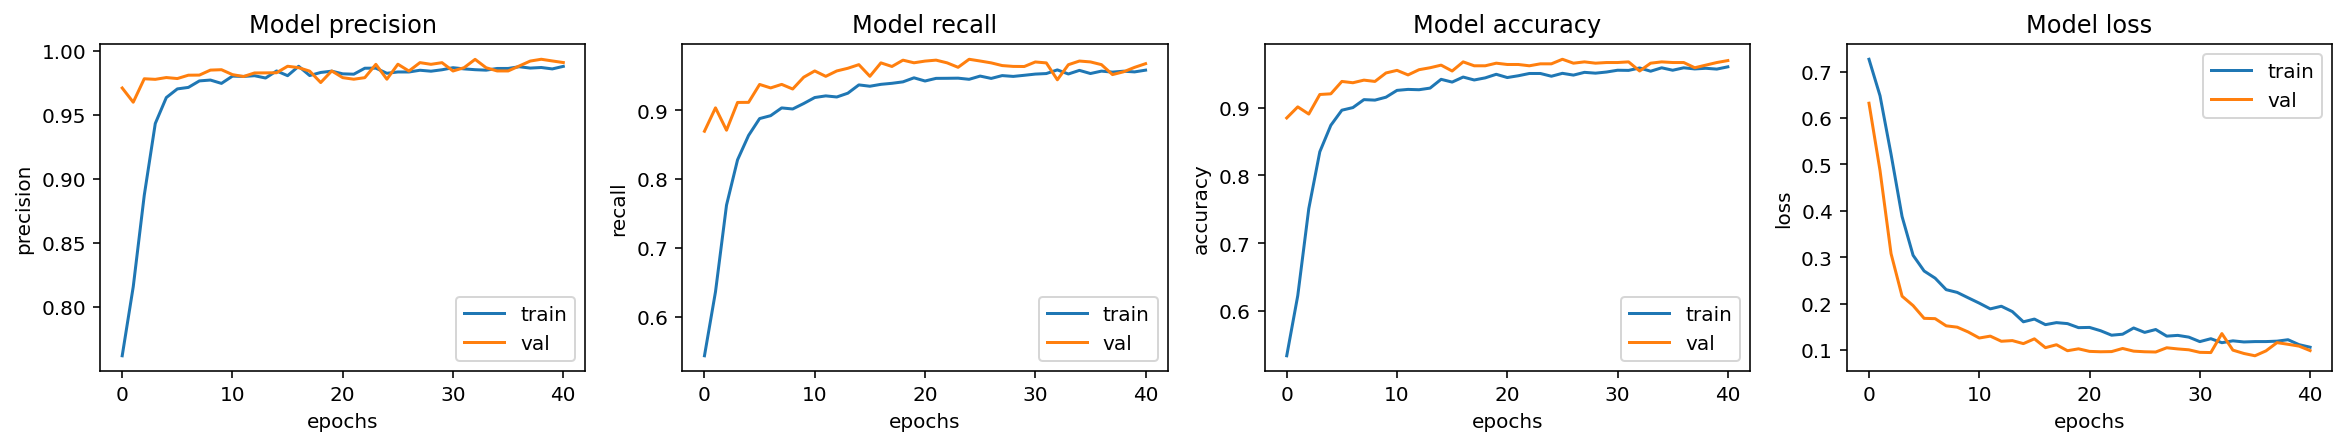

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
model.evaluate(test_ds)

39/39 [==============================] - 4s 109ms/step - loss: 0.4517 - accuracy: 0.8510 - precision: 0.8126 - recall: 0.9897


[0.4516957104206085,
 0.8509615659713745,
 0.8126316070556641,
 0.9897435903549194]

#### Fund #14에서 가져온 코드들

In [31]:
for image_batch, label_batch in test_ds.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[0.9996152 ],
       [0.9999652 ],
       [0.9642745 ],
       [0.9686132 ],
       [0.10116985],
       [0.03400753],
       [0.9975853 ],
       [0.07237677],
       [0.748586  ],
       [0.994589  ],
       [0.36966667],
       [0.84010804],
       [0.9998554 ],
       [0.9746396 ],
       [0.99998426],
       [0.99668413]], dtype=float32)

In [32]:
import numpy as np
#predictions = np.argmax(predictions, axis=1)
predictions = np.round(predictions)
predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

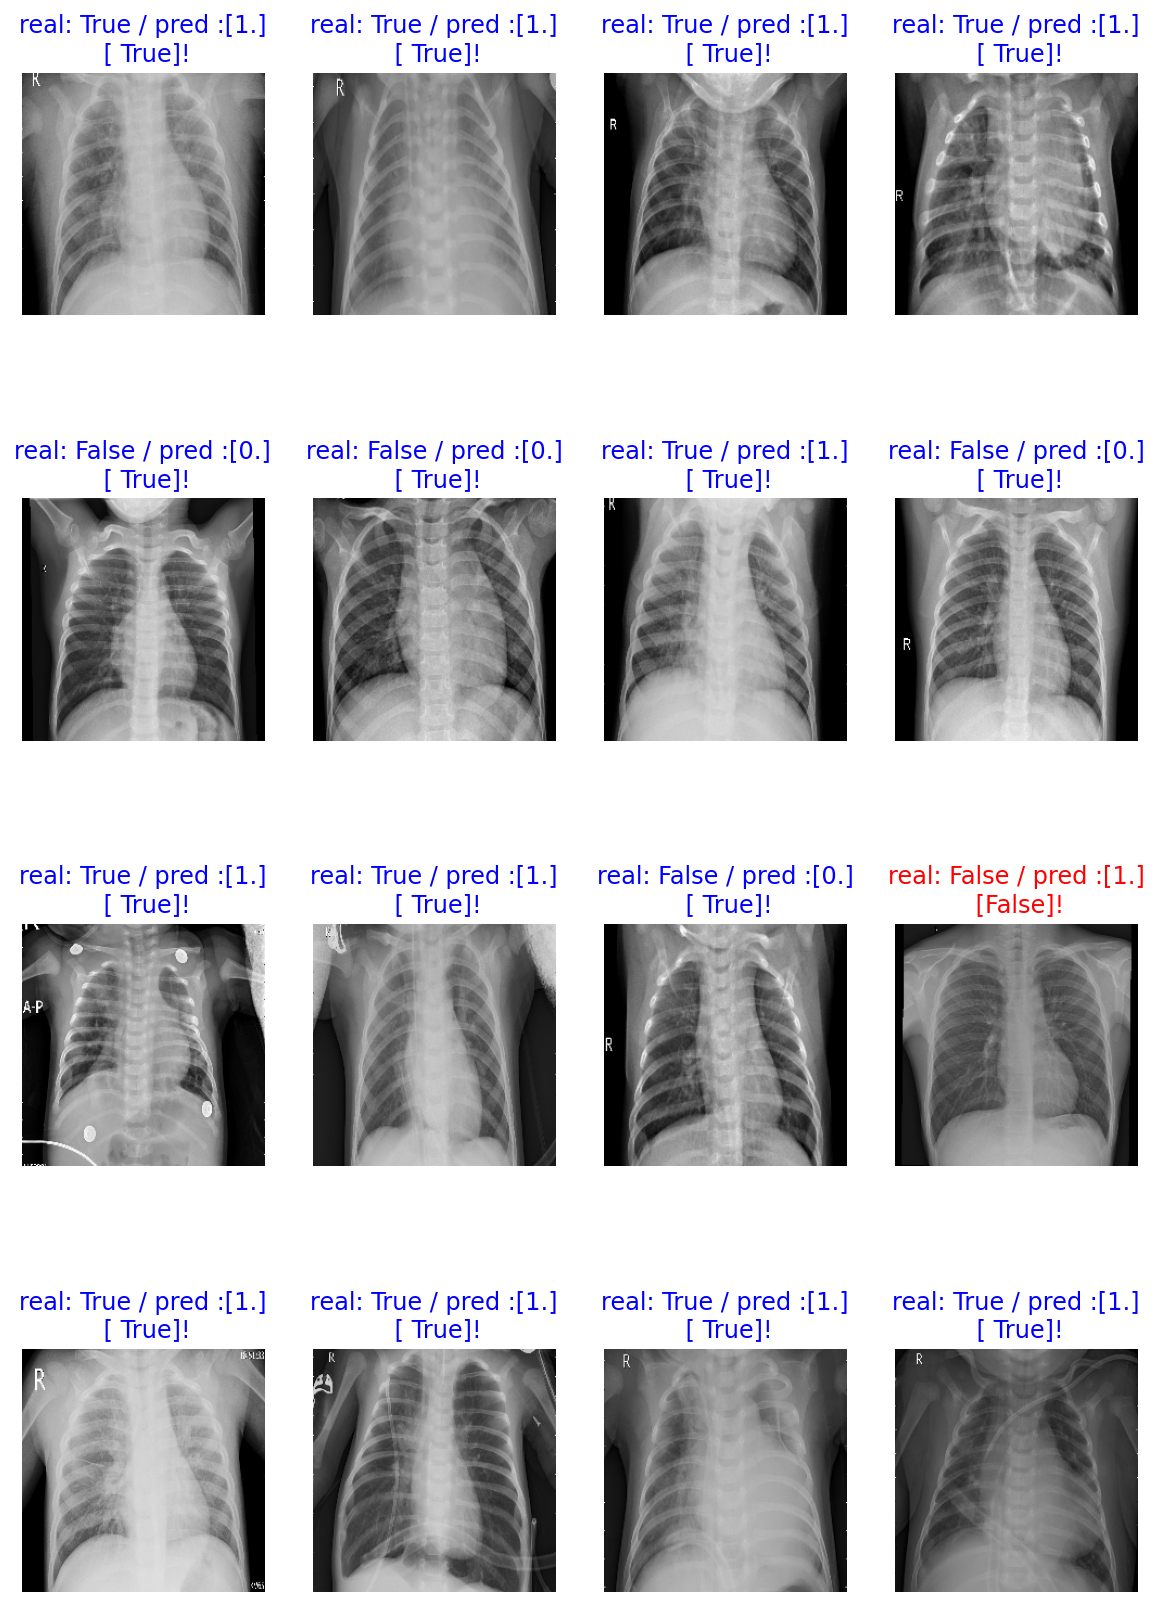

In [33]:
plt.figure(figsize=(10, 15))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), idx+1)
    #image = (image + 1) * 127.5
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# False = class 0 = Normal
# True = class 1 = Pneumonia

In [34]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / BATCH_SIZE * 100) # 약 95% 내외

93.75


## 프로젝트 평가

| 평가문항 | 상세기준 | 실행 결과 | 
|:---|:---|:---:|
| 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. | 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다. | 확인했음 |
| 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. | regularization, augmentation 등의 기법의 사용 여부에 따른 <br> 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다. | 수행했음 |
| 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. | Accuracy 기준 85%에 도달하였다. | 달성 (우연히) |



## 프로젝트 코드 순서

- Step 1. 실험 환경 Setup
- Step 2. 데이터 준비하기: 데이터 전처리
  - 2-1. 각 데이터 개수 확인 후 훈련, 검증 데이터셋 재구성
  - 2-2. train 데이터셋의 정상 이미지 및 폐렴 이미지 개수 확인
  - 2-3. tf.data 인스턴스 만들기
  - 2-4. 라벨 데이터 (함수) 만들기: get_label()
  - 2-5. 이미지 크기 통일 및 줄이기 (함수): decode_img(), process_path()
  - 2-6. 훈련 데이터셋, 검증 데이터셋 만들기전처리 결과 확인
  - 2-7. 훈련, 검증 데이터셋 전처리 결과 확인
  - 2-8. 테스트 데이터셋 전처리 및 결과 확인
  - 2-9. 효율적 훈련(학습)을 위한 훈련 데이터 구성 (함수)
  - 2-10. 좌우 반전 Augmentation 기법 고려
- Step 3. 데이터 시각화
- Step 4. CNN 모델링
  - 4-1. Convolution Block 정의
  - 4-2. Dense Block 정의
  - 4-3. CNN 모델링
  - 4-4. Transfer Learning 모델링 (함수)
- Step 5. 데이터 Imbalance 처리
- Step 6. 모델 훈련
  - 6-1. 모델 구성 및 설정
  - 6-2. 모델 실행
- Step 7. 결과 확인 및 시각화



## Ablation Study

#### [기본 모델] 성능 - 실행시마다 값이 바뀜
- loss: 0.5791 - accuracy: 0.7885 - precision: 0.7520 - recall: 0.9872

#### [변경안_1] 기본 모델 + Augmentation 사용시 (2-9, 2-10 부분 코드 변경) - 실행시마다 값이 바뀜
- loss: 0.4853 - accuracy: 0.8077 - precision: 0.7700 - recall: 0.9872
- loss: 0.8611 - accuracy: 0.7676 - precision: 0.7342 - recall: 0.9846
- loss: 0.4503 - accuracy: 0.8413 - precision: 0.8143 - recall: 0.9667
  <br> <br>
  - Augmentation 사용시 정확도가 높아짐. 기본 모델에 Augmantation 추가!!!

#### [변경안_2] 기본 모델 + Augmentation + Batch Normalization ONLY  - 실행시마다 값이 바뀜
- Convolution층의 Dropout 제거 (4-3 부분 코드 변경). Dense층 Dropout은 유지
  - loss: 0.5582 - accuracy: 0.7853 - precision: 0.7560 - recall: 0.9692
<br> <br>
- Convolution층의 Dropout 제거 (4-3 부분 코드 변경). Dense층 Dropout도 제거 (4-2 부분 코드 변경)
  - loss: 0.9033 - accuracy: 0.7692 - precision: 0.7303 - recall: 1.0000
  <br> <br>
  - Dropout 제거하고 Batch Normalization만 적용하면 정확도 나빠짐!!!

#### [변경안_3] 기본 모델 + Augmentation + Dropout ONLY (4-1, 4-2 코드 수정) - 실행시마다 값이 바뀜
- loss: 0.6893 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

<center> <span style="font-weight:bold; font-size:20px">[결과 정리]</span> </center>

| # | 성능 개선 관련 항목 | 기본 모델 | 변경안_1 | 변경안_2 | 변경안_3 | Remark |
|:---:|:---|:---:|:---:|:---:|:---:|:---|
| 1 | 훈련 조기종료를 <br> 위한 Callback | 적용 | 적용 | 적용 | 적용 | - ModelCheckpoint 콜백과 <br> EarlyStopping(patience=3에서 5로 변경) 동시 적용 <br> - Epoch 수는 넉넉하게 50으로 지정 |
| 2 | batch_size | 16 | 16 | 16 | 16 | BATCH_SIZE = 4, 8, 16, 32, 64를 사용하여 실행한 결과, <span style="color:blue; font-weight:bold; font-size:12px"><br> 16에서 제일 좋은 성능(accuracy 기준)</span>을 보임!!!  |
| 3 | Data Augmentation | 사용 안함 | <span style="color:blue; font-weight:bold; font-size:12px">사용</span> | 사용 | 사용 | 사용시 정확도 올라감. 기본 모델에 추가!!! |
| 4 | **Regularization** <br> - Batch Normalization <br> - Dropout |  <br> - 사용 <br> - 사용 |  <br> - 사용 <br> - 사용 |  <br> - 사용 <br> - **안함** |  <br> - **안함** <br> - 사용 | 동시 사용시 성능이 제일 좋음.  동시 사용으로 결정!!! |
| 5 | Dropout 비율 (%) | Conv층: 20, 20 <br> Dense층: 70, 50, 30 | 기본 모델과 같음 | **N/A** | 기본 모델과 같음 |   |
| 6 | 데이터 불균형 처리 <br> class_weight | 사용 | 사용 | 사용 | 사용 | |
| 7 | Optimizer | adam | adam | adam | adam |  |
| **Test** <br> **성능** | Loss <br> **Accuracy** <br> Precision <br> Recall | 0.5791 <br> **0.7885** <br> 0.7520 <br> 0.9872 | 0.4503 <br> **0.8413** <br> 0.8143 <br> 0.9667 | 0.9033 <br> **0.7692** <br> 0.7303 <br> 1.0000 | 0.6893 <br> **0.6250** <br> 0.6250 <br> 1.0000| |
| **평가** |  |  | **제일 우수**  |  |  |  |

- <span style="color:blue; font-weight:bold; font-size:15px">성능이 제일 우수한 [변경안_1]을 기본으로 하여 CNN 모델 파라미터 튜닝 (목표: accuracy 85% 이상)</span>
  - convolution 층수, 필터(채널) 개수, Optimizer, activation 함수, 모델 구조, dropout 비율 변경 등 가능

#### Dropout 비율 조정: Conv층 50/50, Dense층 70/50/50
- loss: 0.8980 - accuracy: 0.7292 - precision: 0.6998 - recall: 0.9923

#### Dropout 비율 변경, 층 추가 등을 시도해 보았으나 뚜렷한 정확도 개선이 이루어지지 않음 

- loss: 1.0252 - accuracy: 0.7917 - precision: 0.7519 - recall: 0.9949
- loss: 1.0740 - accuracy: 0.7500 - precision: 0.7159 - recall: 0.9949
- loss: 0.6884 - accuracy: 0.8045 - precision: 0.7669 - recall: 0.9872
- 오히려 변경안_1(기본 모델+Augmentation)보다 더 나빠짐... 

#### VGG16에 기반한 Transfer Learning 모델링 수행 (4-4. 참고)
- Convolutional Base는 그대로 두고 Classifier만 새로 학습하는 전략 적용
- "Fundamental 14. 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니?" 내용 구현
- tr_build_model() 함수로 만들어서 실행시켜 보았으나...
  - AttributionError: 'NoneType' object has no attribute 'compile' 에러 발생
    - (관련 사이트) https://stackoverflow.com/questions/62198201/tf-model-subclassing-attributionerror-nonetype-object-has-no-attribute-co
    - tr_build_model()을 함수로 만들지 말고 class로 만들어야 한다고...
    - 시간 관계상 다음 기회에 하기로 하고, 이번에는 함수를 쓰지 않고 직접 코딩해서 실행했음
- 이미지 데이터 전처리에 이미지 픽셀값 정규화(img/127.5 - 1)를 적용한 결과 모델 정확도가 아주 나빠짐
- 거의 모든 파라미터들을 바꾸어 가면서 실행해 보았으나 최고 정확도 83% 수준에서 더 이상의 개선이 이루어지지 않음
- 훈련데이터 수가 적은 것이 원인이 아닐까 추측함
- 다음 조건에서 82~83% 정확도 측정: 각 조건들이 [변경안_1]과 다른 결과를 보이기도 함 
  - (Step 1 부분) 이미지 크기 = 224 x 224: VGG16 이미지 모델 적용. 이미지 크기는 성능에 큰 영향 없음
  - (Step 1 부분) Batch Size = 16: 16에서 정확도 우수한 편
  - (2-10 부분) 데이터 Augmentation: 적용하는 것이 정확도 약간 개선
  - (6-2 부분) 데이터 불균형 해소를 위한 Class_Weight: 적용하지 않는 것이 정확도 약간 개선
  - (6-1 부분) 옵티마이저 Adam, Learning Rate = 0.0001: 특별히 변경하지 않음
  - (6-1 부분) Classifier부분 Dense층 구성: 3개층 구성에서 정확도가 높으며 층 수를 늘려도 정확도 향상 없음
  - (4-2 부분) Batch Normalization 제거, Dropout만 적용: 큰 차이를 보이지 않음

#### 회고
- 결국은 85%가 안 되는군요...
- 이것저것 그동안 배운 것 총 동원해서 해봤으나
- 좌충우돌 짜깁기 하면서 체계도 부족하고 계속 에러나고...
- 많이 부족하지만 그래도 꾸역꾸역 하면서 배우는 것이 많이 있는 듯
...
- 앗!!!! 하늘이 감동했는지 방금 끝난 실행 결과 정확도 85.1% 달성... 헐~
  - loss: 0.4517 - **accuracy: 0.8510** - precision: 0.8126 - recall: 0.9897


<span style="color:red; font-weight:bold; font-size:20px"> 여기까지 완료!!! </span>

#### 오죽하면 이런 것까지... ㅋㅋㅋ
- 파이썬 idle이나 jupyter notebook에서 다음과 같이 beepsound 함수를 만들어서 마지막에 아래 beepsound()를 사용하면 전자레인지 끝나고 나는 소리를 내면서 코드가 종료된 것을 알 수 있다.
- 물론, 코드 어디에 넣어도 관계 없다. 원하는 곳에 beepsound()를 얼마던지 원하는 만큼 넣어서 사용할 수도 있다.

In [35]:
#import winsound as sd
#def beepsound():
#    fr = 2000    # range : 37 ~ 32767
#    du = 1000     # 1000 ms ==1second
#    sd.Beep(fr, du) # winsound.Beep(frequency, duration)
#beepsound()

### ... 그런데 안된다 !!!

이제 Exp #10 하러 가야지...